In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from itertools import combinations
import statsmodels.formula.api as sm
from statsmodels.api import stats as st
from statsmodels.api import ProbPlot, qqline
from IPython.display import display, Markdown, Latex
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_white, het_breuschpagan


AX_SIZE = 10
FIG_WIDTH = 4
FIG_HEIGHT = 2.5

sns.set(font_scale=1.1, rc={"figure.figsize": [FIG_WIDTH, FIG_HEIGHT]})
sns.set_style('white')
sns.set_context('paper')
sns.set_palette('deep')

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 12,
          'figure.dpi':200
          }


plt.rcParams.update(params) 

pd.options.display.precision = 4 # Para 4 decimales.
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def format_plot(ax, x_label = 'x', y_label = 'y', caption = None, despine = True):
    if despine:
        sns.despine()

    if caption:
        x_label = x_label + '\n\n' + caption

    ax.set_xlabel(x_label, fontsize = AX_SIZE)
    ax.set_ylabel(y_label, fontsize = AX_SIZE)

Construir un modelo de regresion lineal que explique o aproxime el precio de los vehículos (`msrp`) híbridos en la base de datos como función delas variables y/o factores: 

* tasa de aceleración (`accelrate`)
* consumo de combustible (`mpg`)
* máximo de consumo de combustible o equivalente (`mpgmpge`)
* modelo (`vehicle`)
* clase del vehículo  (`carclass`)

# Realice un análisis exploratorio de los datos y reporte lo que considere relevante

In [3]:
#df = pd.concat([pd.read_csv('datosFit.csv'), pd.read_csv('datosFin.csv')]).reset_index(drop = True)
df = pd.read_csv('datosFit.csv')

In [4]:
data = df[['vehicle', 'accelrate', 'carclass']]
data['mpg'] = df['mpg'] * 0.425144
data['mpgmpge'] = df['mpgmpge'] * 0.425144
data['msrp'] = df['msrp'] / 1000

La base de datos se compone de 153 observaciones de diferentes coches y no tenemos datos faltantes ni repetidos. Existen 109 modelos de coches distintos y 7 clases.

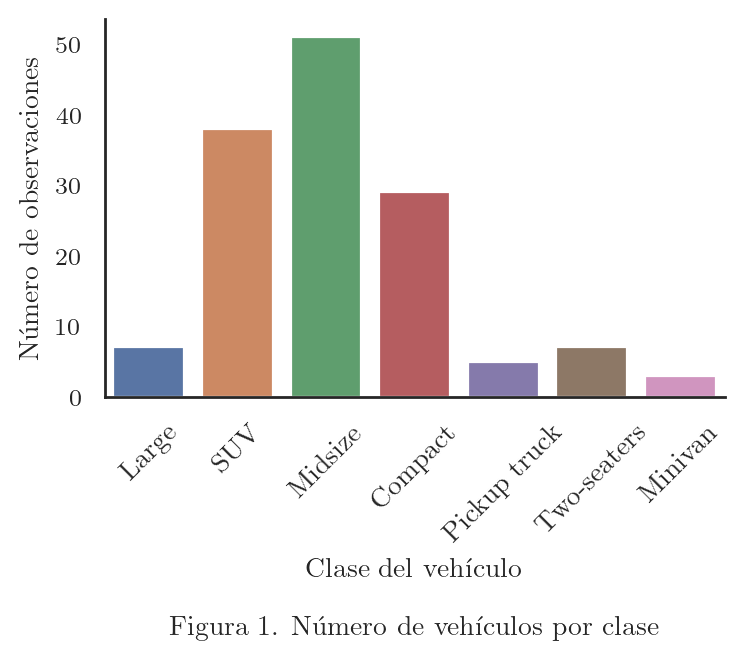

In [5]:
fig, axes = plt.subplots(1, 1)
sns.countplot(x = 'carclass', data = data, ax = axes)
axes.set_xticklabels(
    labels = ['Large', 'SUV', 'Midsize', 'Compact', 'Pickup truck', 'Two-seaters', 'Minivan'],
    rotation = 45,
    fontsize = AX_SIZE
)
format_plot(
    ax = axes,
    x_label = 'Clase del vehículo',
    y_label = 'Número de observaciones',
    caption = 'Figura 1. Número de vehículos por clase'
)
plt.show()

De la Figura 1 vemos que hay más carros de tamaño medio, seguido por las SUV y los autos compactos, por lo que la mayoría de los datos de la base son coches familiares donde caben más de 3 personas. Creamos una nueva variable para las clases de coche que agrupa los coches similares en una clase. Los nuevos grupos están dados por:

 * Carros grandes: Large y Pickup Truck (`Large`)
 * Camionetas: SUV y Minivan (`Vans`)
 * Carros pequeños: Compact y Two-seaters (`Small`)
 * Carros medianos: Midsize (`Medium`)

In [6]:
conditions = [
    (data['carclass'] == 'SUV') |  (data['carclass'] == 'MV'),
    (data['carclass'] == 'L') |  (data['carclass'] == 'PT'),
    (data['carclass'] == 'C') |  (data['carclass'] == 'TS'),
    (data['carclass'] == 'M')
]
choices = [
    'Vans',
    'Large',
    'Small',
    'Medium'
]
data['newCarClass'] = np.select(conditions, choices)

In [7]:
vehicles = {}
for model in data.vehicle.unique():
    key = model.split()[0]
    
    if key in vehicles:
        vehicles[key].append(model)
    else:
        vehicles[key] = [model]

conditions = []
choices = []
for key, values in vehicles.items():
    for model in values:
        conditions.append(df['vehicle'] == model)
        choices.append(key)
data['model'] = np.select(conditions, choices)

In [8]:
brand = {
    'BMW': ['ActiveHybrid', ],
    'Mercedes-Benz': ['ML450', 'S400', 'E400'],
    'Toyota': ['Crown', 'Prius', 'SAI', 'Highlander', 'Auris', 'Camry', 'Kluger', 'Estima'],
    'BYD': ['F3DM'],
    'Lexus': ['ES', 'CT', 'GS', 'Lexus', 'RX'],
    'Chevrolet': ['Silverado', 'Tahoe', 'Malibu', 'Chevrolet'],
    'Honda': ['Civic', 'CR-Z', 'Fit', 'Insight', 'Freed/Freed', 'ILX', 'Fit/Jazz', 'Accord'],
    'Nissan': ['Altima', 'Tino', 'Fuga'],
    'Cadillac': ['Cadillac', 'Escalade'],
    'Dodge': ['Aspen'],
    'Ford': ['Escape', 'Fusion', 'C-Max', 'Mercury', 'Mariner'],
    'Audi': ['A5', 'Q5', 'Audi'],
    'Kia': ['Optima'],
    'Infiniti': ['M35h'], 
    'Volkswagen': ['Touareg', 'Jetta'],
    'Opel': ['Ampera', 'Vue'], 
    'GMC': ['Yukon', 'Sierra', 'GMC'],
    'Mazda': ['Tribute'],
    'Lincoln': ['MKZ', 'Lincoln'],
    'Hyundai': ['Sonata', 'Avante/Elantra', 'Aura'], 
    'Porsche': ['Panamera', 'Cayenne'], 
    'Jeep': ['Jeep'],
    'Besturn': ['Besturn'],
    'Buick': ['Buick', 'LaCrosse'], 
    'Peugeot': ['3008']
}

conditions = []
choices = []
for key, values in brand.items():
    for model in values:
        conditions.append(data['model'] == model)
        choices.append(key)
data['manufacturer'] = np.select(conditions, choices)


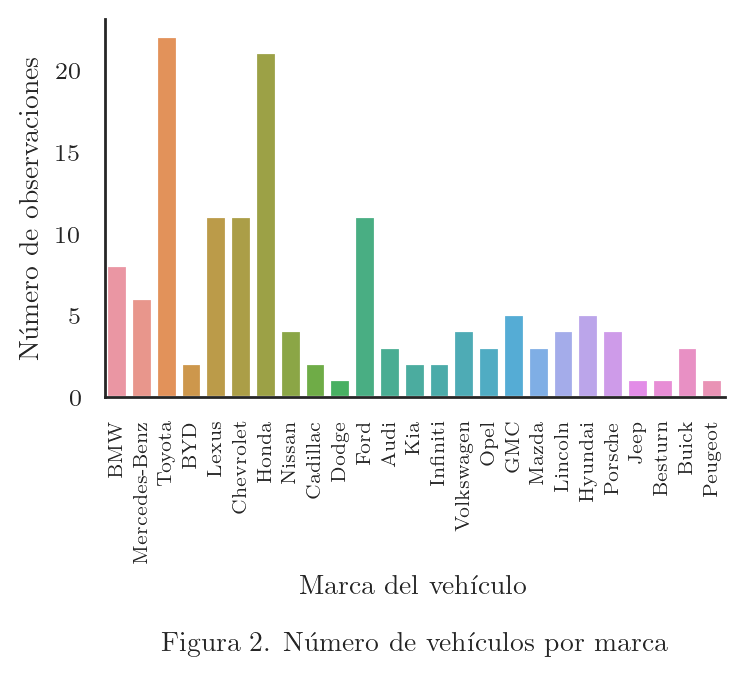

In [9]:
fig, axes = plt.subplots(1, 1)
sns.countplot(x = 'manufacturer', data = data, ax = axes)
axes.set_xticklabels(
    labels = data.manufacturer.unique(),
    rotation = 90,
    fontsize = 7
)
format_plot(
    ax = axes,
    x_label = 'Marca del vehículo',
    y_label = 'Número de observaciones',
    caption = 'Figura 2. Número de vehículos por marca'
)
plt.show()

De igual manera se creó una nueva variable para el modelo de coche que agrupa los modelos por marca, por ejemplo: *Prius*, *Highlander* y *Camry* son de la marca *Toyota*. De esta manera, la nueva variable `manufacturer` se redujo a 25 clases en lugar de las 109 de la variable `vehicle`. En la Figura 2. vemos que *Toyota*, *Honda*, *Lexus*, *Chevrolet* y *Ford* son las marcas con más observaciones.

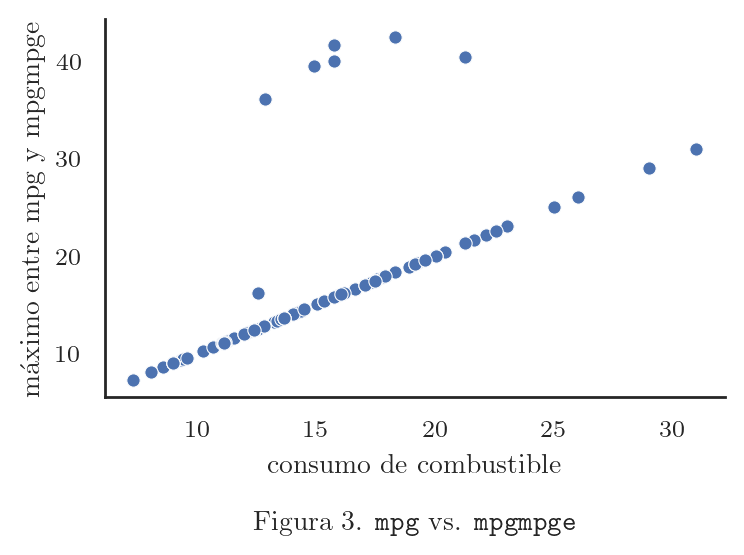

In [10]:
diff_indices = np.where(data['mpg'] != data['mpgmpge'])
different = data.loc[diff_indices]
different = different.sort_values(by = 'mpgmpge')


fig, axes = plt.subplots(1, 1)
sns.scatterplot(x = 'mpg', y = 'mpgmpge', data = data)
format_plot(
    ax = axes,
    x_label = 'consumo de combustible',
    y_label = 'máximo entre mpg y mpgmpge',
    caption = 'Figura 3. \\texttt{mpg} vs. \\texttt{mpgmpge}'
)
plt.show()

Para la mayoría de las observaciones el consumo de combustible es igual al máximo entre el `mpg` y la medición alternativa del consumo de combustible. Sin embargo, hay 10 observaciones en las que la medición alternativa es más del doble de `mpg` (Figura 3).

A continuación evaluaremos la relación entre los regresores y la variable objetivo 

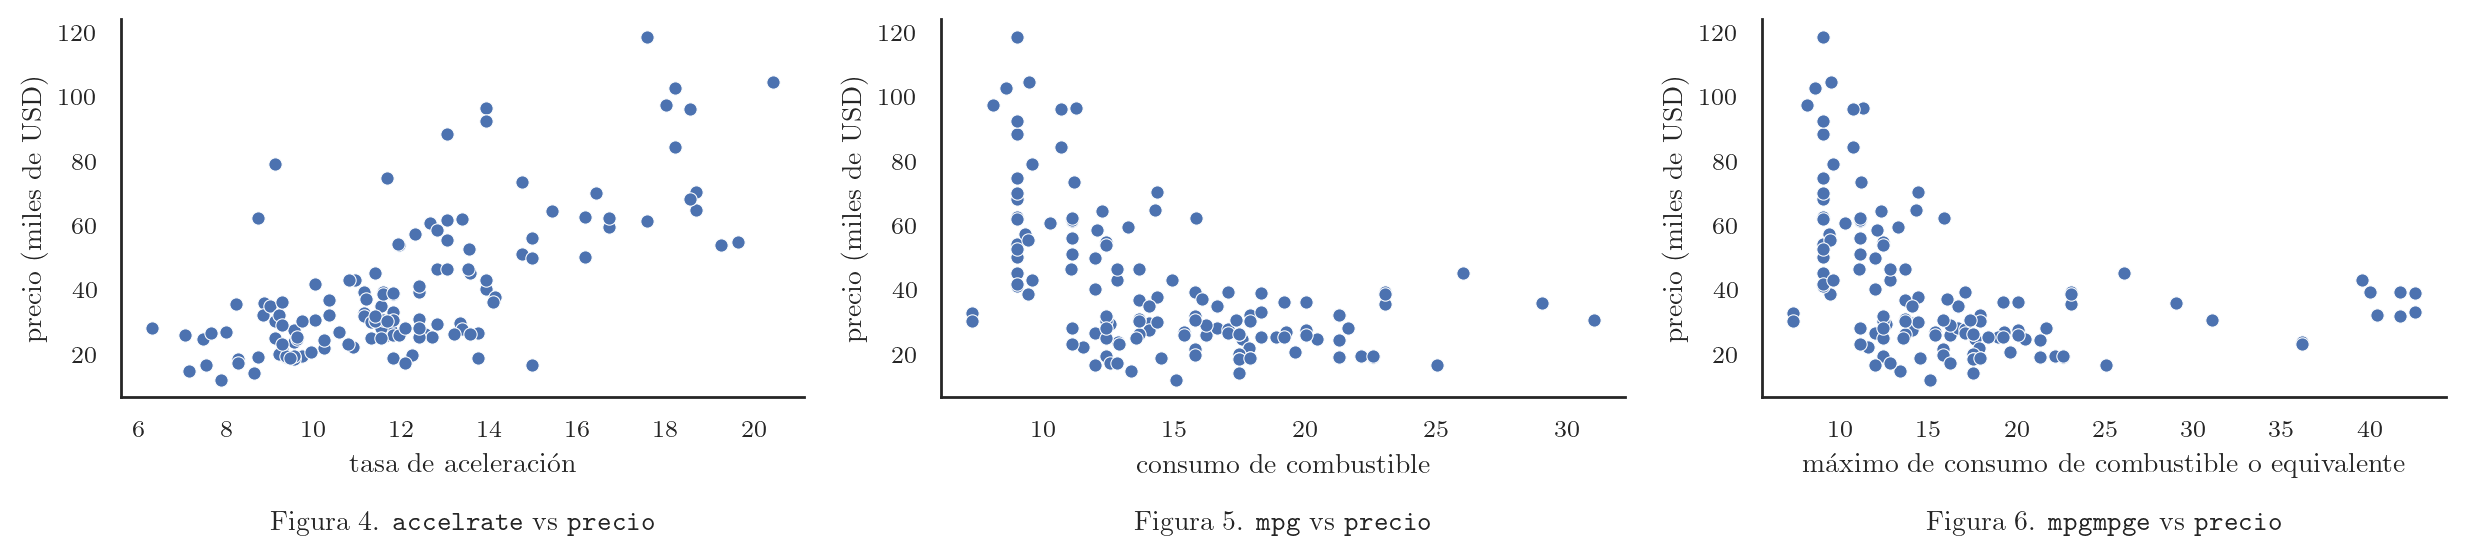

In [11]:
fig, axes = plt.subplots(1, 3, figsize = ((FIG_WIDTH+1)*3, FIG_HEIGHT))
xs = ['accelrate', 'mpg', 'mpgmpge']
labels  = ['tasa de aceleración', 'consumo de combustible', 'máximo de consumo de combustible o equivalente']
captions = ['\\texttt{accelrate}', '\\texttt{mpg}', '\\texttt{mpgmpge}']

i = 4
for x, label, ax, c in zip(xs, labels, axes, captions):
    # accelrate
    sns.scatterplot(x = x, y = 'msrp', data = data, ax = ax)
    caption = f'Figura {i}. '
    caption += c
    caption += ' vs \\texttt{precio}'
    format_plot(
        ax = ax,
        x_label = label,
        y_label = 'precio (miles de USD)',
        caption = caption
    )
    i += 1

plt.show()

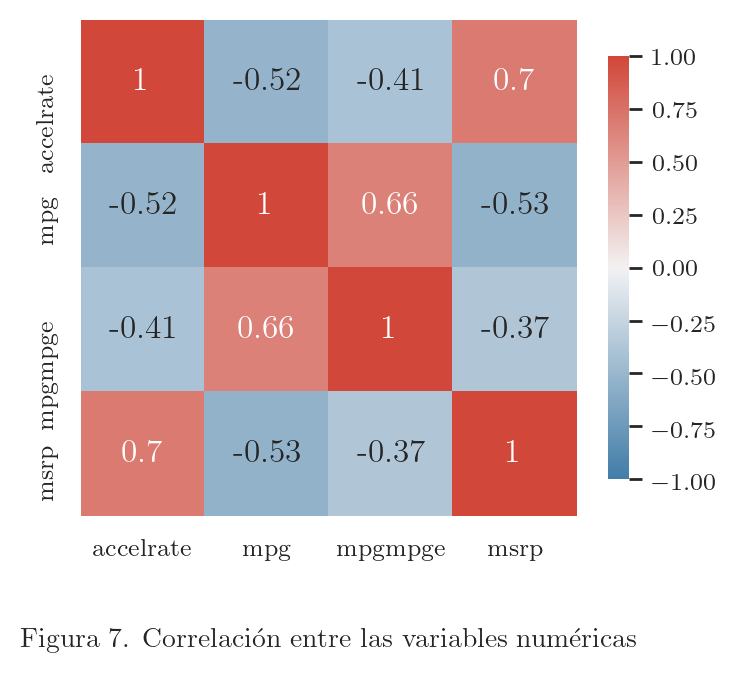

In [12]:
plt.figure(figsize=(4, 4))
cmap = sns.diverging_palette(240, 15, as_cmap=True)
ax = sns.heatmap(data.corr(),
            vmin = -1,
            square=True,
            cmap=cmap,
            annot=True,
            cbar_kws={"shrink": .7}
)

format_plot(
    ax = ax,
    despine = False,
    x_label = '', 
    y_label = '',
    caption = 'Figura 7. Correlación entre las variables numéricas'
)

plt.show()

La tasa de aceleración es la única que presenta una correlación lineal clara con el precio (Figura 4). Tanto para el consumo de combustible como para el máximo de consumo de combustible o equivalente, la relación con la variable objetivo es no-lineal (Figura 5 y 6). También podemos ver que las variables `mpg` y `mpgmpge` tienen un comportamiento similar, lo cual tiene sentido ya que solo difieren en 11 observaciones.

Esto se puede confirmar en la Figura 7 ya que `accelrate` tiene una correlación de $0.7$ con la variable objetivo, mientras que para `mpg` y `mpgmpge`, además de que las correlaciones son negativas, estas no son muy grandes.

# Pregunta 4

## Modelo inicial

In [47]:
formula = 'msrp~accelrate+mpg+mpgmpge+newCarClass+manufacturer'
model = sm.ols(formula=formula, data = data)
fitted = model.fit()

In [48]:
txt = 'Vemos que `mpg` no es significativo pues tiene un valor-p ${:.3f} > 0.05$'.format(fitted.pvalues['mpg'])
display(Markdown(txt))

Vemos que `mpg` no es significativo pues tiene un valor-p $0.081 > 0.05$

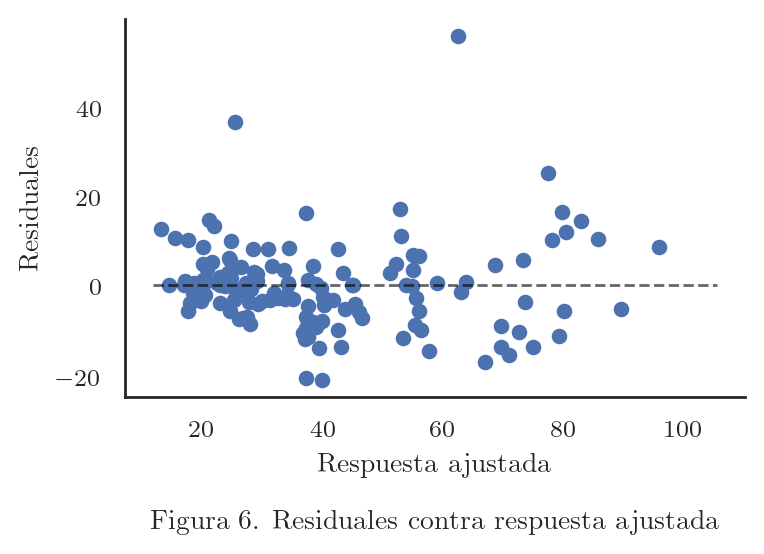

In [49]:
fig, axes = plt.subplots(1, 1)
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, fitted.resid)

format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales',
    caption = 'Figura 6. Residuales contra respuesta ajustada'
)
plt.show()

## Transformación de variables

<font color='red'>Justificar transformacion xq el 0 es el óptimo</font>

In [31]:
def get_boxcox(y, y_gmean, l):
    if l != 0:
        aux = np.power(y, l)-1
        return aux/(l*np.power(y_gmean, l-1))
    else:
        return y_gmean*np.log(y)
    
def get_lambda(df, regresors, y, l_lb = -1, l_ub = 1,  num_l = 9):
    y_gmean = stats.mstats.gmean(df[y])
    
    lambdas = np.linspace(l_lb, l_ub, num_l)
    SS_trans_res = []
    
    for l in lambdas:
        trans_df = df[regresors]
        trans_df['yBoxCox'] = get_boxcox(y = df[y], l = l, y_gmean = y_gmean)
        formula = 'yBoxCox~{}'.format('+'.join(regresors))
        model = sm.ols(formula=formula, data = trans_df)
        fitted = model.fit()
        SS_trans_res.append(fitted.mse_resid*fitted.df_resid)

    min_index = SS_trans_res.index(min(SS_trans_res))
    l = lambdas[min_index]
    classification = [" " for i in range(0,len(lambdas))]
    classification[min_index] = "Óptimo"

    dictionary = {"$\lambda$": lambdas, "$SC_{{Res}}(\lambda)$": SS_trans_res, "Clasificación": classification}
    lambda_df = pd.DataFrame.from_dict(dictionary)
    return lambda_df

In [32]:
regresors = ['accelrate', 'mpgmpge', 'newCarClass', 'manufacturer']
lambda_df = get_lambda(
    df = data,
    regresors = regresors,
    y = 'msrp',
    l_lb = -1,
    l_ub = 1, 
    num_l = 9
)
lambda_df

,$\lambda$,$SC_{{Res}}(\lambda)$,Clasificación
0,-1.00,10269.7716,
1,-0.75,8874.2238,
2,-0.50,7989.9042,
3,-0.25,7546.4395,
4,0.00,7525.9739,Óptimo
5,0.25,7963.9670,
6,0.50,8959.1730,
7,0.75,10695.3245,
8,1.00,13479.5726,


In [33]:
res = stats.boxcox(data['msrp'], alpha = 0.05)
print('lambda: {:.3f}'.format(res[1]))
print('CI: {}'.format(res[2]))

lambda: -0.356
CI: (-0.6767251775288341, -0.037340931198571285)


## Modelo final

In [34]:
data_fin = pd.DataFrame()
data_fin['msrp'] = stats.boxcox(x = data['msrp'], lmbda = 0)
data_fin['mpg'] = data['mpg']
data_fin['mpgmpge'] = data['mpgmpge']
data_fin['carclass'] = data['newCarClass']
data_fin['accelrate'] = data['accelrate']
data_fin['manufacturer'] = data['manufacturer']

In [35]:
def fit_model(regresors, df):
    formula = 'msrp~{}'.format('+'.join(regresors))
    model = sm.ols(formula=formula, data = df)
    fitted = model.fit()
    
    pval = str(fitted.f_pvalue)
    int_, extra = pval.split('.')
    decimal, exp = extra.split('e')
    decimal = decimal[:3]
    f_pvalue = '{}.{}e{}'.format(int_,decimal,exp)
    
    classes_nonsig = 0
    manufacturers_nonsig = 0
    others = []
    for regresor, p in zip(fitted.pvalues.index, fitted.pvalues):
        if p > 0.05:
            if 'carclass' in regresor:
                classes_nonsig += 1
            elif 'manufacturer' in regresor:
                manufacturers_nonsig += 1
            else:
                others.append(regresor)
                
    if 'carclass' in regresors:
        classes_nonsig = np.round((classes_nonsig/data_fin.carclass.nunique())*100,2)
    else:
        classes_nonsig = '-'
        
    if 'manufacturer' in regresors:
        manufacturers_nonsig = np.round((manufacturers_nonsig/data_fin.manufacturer.nunique())*100,2)
    else:
        manufacturers_nonsig = '-'
        
    # mallows cp
    n = data.shape[0]
    q = fitted.params.shape[0]#len(regresors)
    cp = ((fitted.mse_model*fitted.df_resid)/fitted.mse_model) - n + 2*q
    
    d = {
        'model': '+'.join(regresors),
        'num_regresors': q,
        'AIC': np.round(fitted.aic, 3),
        'Mallows Cp': cp,
        'f_pvalue': f_pvalue,
        'R2 adj': np.round(fitted.rsquared_adj*100, 2),
        '% carclass ns': classes_nonsig,
        '% manufacturer ns': manufacturers_nonsig,
        'others': ','.join(others)
    }
    
    return d

In [36]:
possible_regresors = ['mpg', 'mpgmpge', 'carclass', 'accelrate', 'manufacturer']
m = len(possible_regresors)
params = [r for n in range(1, m+1) for r in combinations(possible_regresors, n)]# if 'accelrate' in r]

models_info = []
for regresors in params:
    models_info.append(
        fit_model(regresors = regresors, df = data_fin)
    )

models_df = pd.DataFrame(models_info)
models_df = models_df[models_df['others'] == '']
models_df = models_df.drop(columns = 'others')
models_df

,model,num_regresors,AIC,Mallows Cp,f_pvalue,R2 adj,% carclass ns,% manufacturer ns
0,mpg,2,156.077,2.0,2.313e-11,27.22,-,-
1,mpgmpge,2,185.046,2.0,5.609e-05,10.49,-,-
2,carclass,4,164.835,4.0,1.225e-08,23.60,0,-
3,accelrate,2,109.445,2.0,1.850e-21,47.84,-,-
4,manufacturer,25,59.143,25.0,1.594e-23,68.54,-,56
6,mpg+carclass,5,152.226,5.0,5.940e-11,30.66,25,-
7,mpg+accelrate,3,100.821,3.0,1.466e-22,51.30,-,-
8,mpg+manufacturer,26,53.568,26.0,3.362e-24,69.93,-,56
12,carclass+accelrate,5,94.008,5.0,6.403e-23,54.25,25,-
13,carclass+manufacturer,28,50.344,28.0,3.202e-24,70.94,50,60


In [37]:
formula = 'msrp~mpgmpge+carclass+accelrate+manufacturer'
model = sm.ols(formula=formula, data = data_fin.drop(index = []))
fitted = model.fit()

### Outliers detection

<font color='red'>Detectamos dos casos atípicos con los residuales estandarizados pero como no son errores de medición se dejan. Con Cooks Distance no resaltó ningún dato.</font>

In [38]:
influence = fitted.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance
cooks_d = [x[0] for x in cooks_d]

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

#studentized residuals
studentized_residuals = influence.resid_studentized_external

print('\nH:')
p = len(fitted.params) - 1
n = data.shape[0]
threshold = 2*p/n
apalancamiento = []
for i, h_ii in enumerate(leverage):
    if np.abs(h_ii) > threshold:
        apalancamiento.append(i)
        
df_leverage = data.loc[apalancamiento]
df_leverage = df_leverage[df_leverage['newCarClass'] != 'Large']
apalancamiento = df_leverage.index.tolist()
print(apalancamiento)

print('\nStd:')
s = np.sqrt(fitted.mse_resid)
std_resid = fitted.resid/s
outliers = []
for i, e in enumerate(standardized_residuals):
    if np.abs(e) > 3:
        print('{} es atipico {:.2f}'.format(i, e))
        outliers.append(i)
        
print('\nCooks:')
D = (np.square(standardized_residuals) * leverage)/(p*(1-leverage))
cooks = []
for i, d in enumerate(cooks_d):
    if d > 1:
        print('{} es influyente {:.2f}'.format(i, d))
        cooks.append(i)
        
cooks = 19


H:
[3, 15, 16, 17, 19, 24, 30, 62, 72, 100, 105, 127, 130]

Std:
2 es atipico 4.12
89 es atipico 3.60

Cooks:


/Users/andreamarin/.pyenv/versions/3.7.8/envs/aprendizaje-maquina/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


2
89


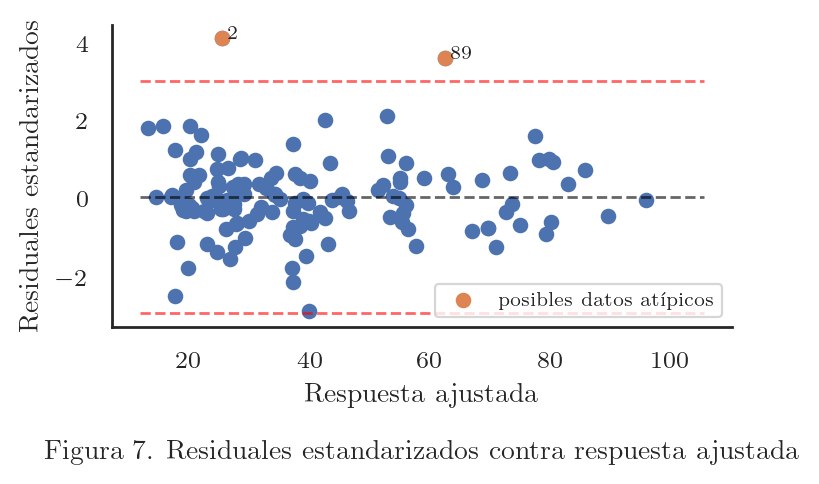

In [106]:
fig, axes = plt.subplots(1, 1, figsize=(4, 2))
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=3, xmin=xmin*0.9, xmax=xmax*1.1, color='red',linestyle='--',lw=1, alpha = 0.6)
axes.hlines(y=-3, xmin=xmin*0.9, xmax=xmax*1.1, color='red',linestyle='--',lw=1, alpha = 0.6)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, standardized_residuals)
axes.scatter(fitted.fittedvalues[outliers], standardized_residuals[outliers], label = 'posibles datos atípicos')
plt.legend(loc = 4, fontsize = 7)
format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales estandarizados',
    caption = 'Figura 7. Residuales estandarizados contra respuesta ajustada'
)

for i in outliers:
    print(i)
    axes.annotate(i, 
                  xy=(fitted.fittedvalues[i]+0.9, standardized_residuals[i]),
                  size = 7
                 )

plt.show()

### Validación del modelo

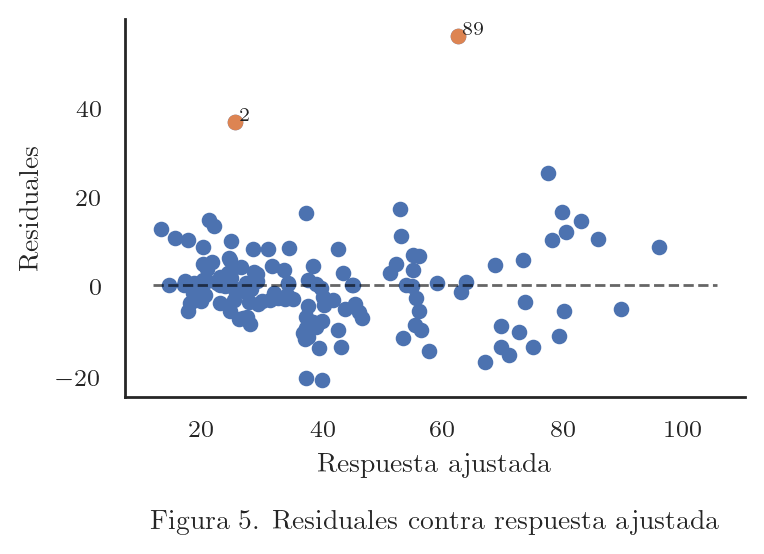

In [102]:
fig, axes = plt.subplots(1, 1)
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, fitted.resid)

## Quitar esto para no graficar outliers
axes.scatter(fitted.fittedvalues[outliers], fitted.resid[outliers])

for i in outliers:
    axes.annotate(i, 
                  xy=(fitted.fittedvalues[i]+0.9, fitted.resid[i]+0.5),
                  size = 7
                 )

format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales',
    caption = 'Figura 5. Residuales contra respuesta ajustada'
)
plt.show()

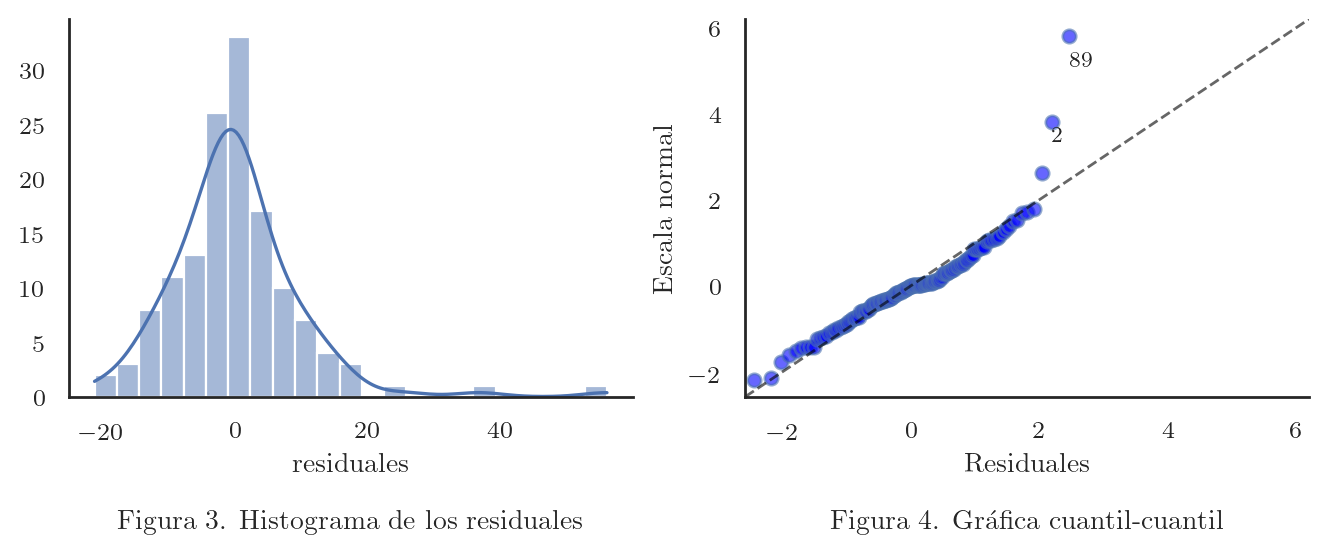

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
# Histograma
sns.histplot(fitted.resid, ax = axes[0], kde = True)
format_plot(
    ax = axes[0],
    x_label = 'residuales',
    y_label = '',
    caption = 'Figura 3. Histograma de los residuales'
)
#Gráfica cuantil-cuantil
pp = ProbPlot(fitted.resid_pearson, fit=True)
qq = pp.qqplot(alpha=0.6, ax = axes[1])

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(fitted.resid_pearson)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:2]

for r, i in enumerate(abs_norm_resid_top_3):
    axes[1].annotate(i, 
                     xy=(np.flip(pp.theoretical_quantiles, 0)[r],
                                   fitted.resid_pearson[i]),
                    size = 8)    


qqline(qq.axes[1], line='45', color='black',linestyle='--',lw=1, alpha = 0.6)
format_plot(
    axes[1],
    x_label = 'Residuales',
    y_label = 'Escala normal',
    caption = 'Figura 4. Gráfica cuantil-cuantil'
)
plt.show()


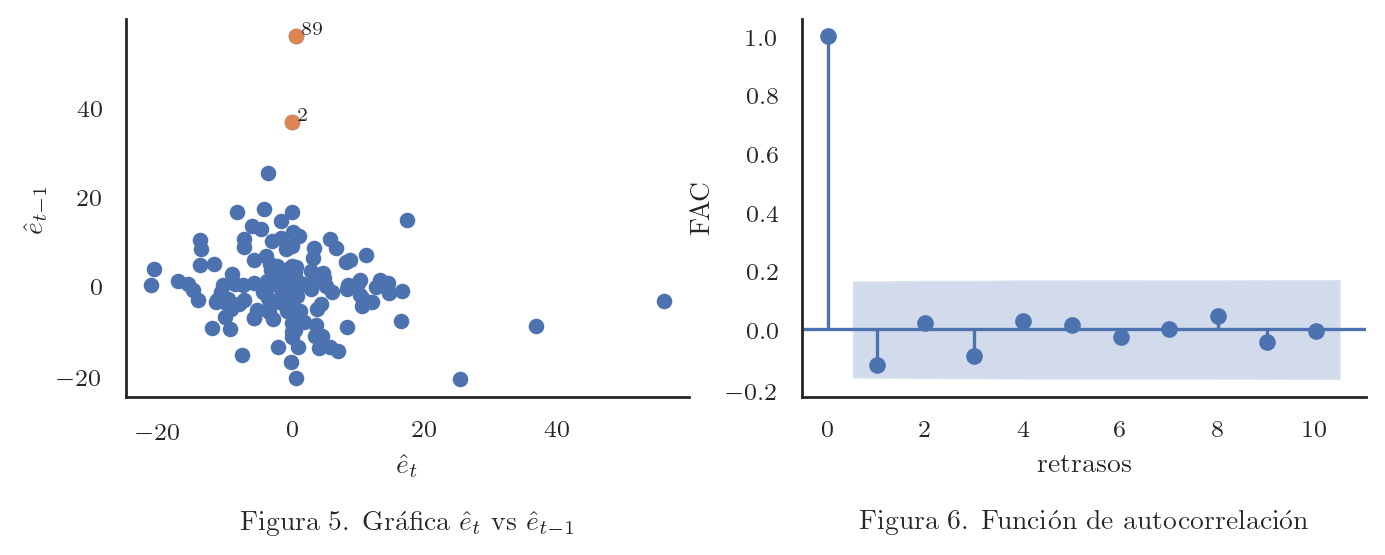

In [120]:
#------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
#plot acf
e1 = list(fitted.resid)
e = e1[:-1]
e1 = e1[1:]
axes[0].scatter(x = e1, y = e)

# quitar si no se grafican outliers
axes[0].scatter(x = np.array(e1)[outliers], y = np.array(e)[outliers])
for i in outliers:
    axes[0].annotate(i, 
                  xy=(e1[i]+0.9, e[i]+0.5),
                  size = 7
                 )
    
format_plot(
    axes[0],
    x_label = '$\hat{e}_t$',
    y_label = '$\hat{e}_{t-1}$',
    caption = 'Figura 5. Gráfica $\hat{e}_t$ vs $\hat{e}_{t-1}$'
)
smt.graphics.plot_acf(
    fitted.resid, 
    lags=10, 
    alpha=0.05,
    ax = axes[1],
    title = ''
)
format_plot(
    axes[1],
    x_label = 'retrasos',
    y_label = 'FAC',
    caption = 'Figura 6. Función de autocorrelación'
)
plt.show()

<font color='red'>Comentar acerca del punto 2 y el 89 (??)</font>

In [123]:
# coches muy caros dentro de su categoría (???)
data.loc[outliers]

,vehicle,accelrate,carclass,mpg,mpgmpge,msrp,newCarClass,model,manufacturer
2,Crown,8.70,M,15.7984,15.7984,62.2904,Medium,Crown,Toyota
89,Lexus LS600h/hL,17.54,M,8.9280,8.9280,118.5436,Medium,Lexus,Lexus


# Pregunta 5

<font color='red'>Dar intervalos de confianza para las predicciones y el valor de R^2 de la predicción (pg 377 Montgomery inglés)</font>